
<a id="ref1"></a>
<h2>Libraries</h2>

In [26]:
# Standard Libraries
import os
import re
import json
import time
import string
import warnings
from dotenv import load_dotenv
import os
from openai import OpenAI
import pandas as pd
from collections import Counter

# Third-Party Libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output

# Scientific and Computational Libraries
from scipy.spatial import ConvexHull
from scipy import interpolate

# NLP Libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Text Processing Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Machine Learning Libraries
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Dimensionality Reduction and Clustering Libraries
import umap
import hdbscan

# Custom/Other Libraries
from pointgrid import align_points_to_grid

# Polarization Libraries
import nltk
from nltk.corpus import opinion_lexicon


<a id="ref2"></a>
<h2>Data</h2>

In [27]:
# Load the dataset
df = pd.read_csv("data.csv")

# Clean: drop unnecessary columns and reset index
df = df.drop(['contentMarketingPublisher', 'summary_shot_title', 'type'], axis=1)
df = df.reset_index(drop=True)

# Filter to ensure 'bodytext' column contains valid strings
df = df[df['bodytext'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

df['published'] = df['published'].str.strip() # Clean the 'published' column: trim whitespace and ensure it's a valid datetime
df['published'] = pd.to_datetime(df['published'], errors='coerce', utc=True) # Convert with utc=True to handle mixed time zones
df['year'] = df['published'].dt.year # Extract the year from the 'published' column
df = df.dropna(subset=['year']).reset_index(drop=True) # Drop rows where the 'year' couldn't be extracted
df['year'] = df['year'].astype(int) # Convert 'year' to integer for further processing

# Display dataset statistics
print(f"The dataset contains {df.shape[0]} articles after filtering and extracting the year\n")

# Sample a few rows for inspection
df.sample(3)

The dataset contains 16709 articles after filtering and extracting the year



,bodytext,created,created_by_name,id,published,published_url,subtitle,tags,title,year
2700,For bare én måned siden gjestet Leif Magne Sva...,2022-10-10T19:48:59+02:00,"Holm, Per Annar",493073.0,2022-10-10 18:45:29+00:00,/leif-magne-helgesen-ukraina/jeg-kjenner-jo-pa...,Sjømannsprest Leif Magne Helgesen (62) har vær...,"ukraina, leif magne helgesen, nyheter",– Jeg kjenner jo på frykten,2022
7368,90 prosent av barn som har fått støtte gjennom...,2019-06-23T12:00:00+02:00,"Woldbrand Guldstad, Alexander",181355.0,2019-06-23 10:00:00+00:00,/leserinnlegg/takk-for-heiarop-gjennom-70-ar/1...,Anne Lise Klungseth på vegne av SOS barnebyer,"meninger, leserinnlegg",Takk for heiarop gjennom 70 år,2019
3204,Svalbardposten har tidligere omtalt saken da d...,2022-05-02T16:00:00+02:00,"Woldbrand Guldstad, Alexander",230941.0,2022-05-02 14:00:00+00:00,/grensekontroll-sysselmesteren-tollkontroll/sk...,Ny grenselov trådte 1. mai i kraft. For Svalba...,"sysselmesteren, grensekontroll, tollkontroll, ...",Skal kontrollere reisende til og fra Svalbard,2022


## Word Count

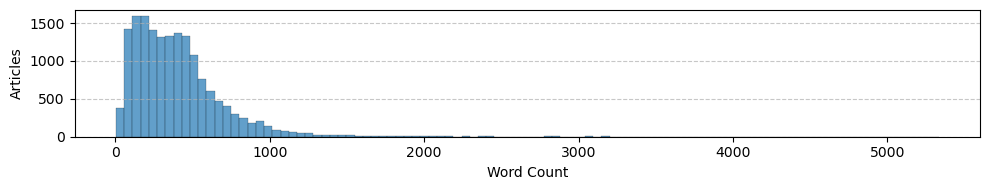

In [28]:
# Calculate and filter word count
df["word_count"] = df["bodytext"].str.split().str.len()
# df = df[df["word_count"].between(500, 6000)]

# Plot histogram
plt.figure(figsize=(10, 2))
plt.hist(df["word_count"], bins=100, edgecolor="black", alpha=0.7, linewidth=0.2)
plt.xlabel("Word Count")
plt.ylabel("Articles")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Parsing

In [29]:
# Load spaCy model
nlp = spacy.load("nb_core_news_sm") # Small Model
# nlp = spacy.load("en_core_web_trf") # Large Model

# Enable tqdm for pandas
tqdm.pandas()

# Parse text column with a progress bar
start_time = time.time()
df['parsing'] = df['bodytext'].progress_apply(nlp)
elapsed_time = time.time() - start_time

print(f"Processing completed in {elapsed_time:.2f} seconds.")

100%|██████████| 16709/16709 [07:40<00:00, 36.31it/s]

Processing completed in 460.23 seconds.


## Tokenization

In [30]:
# Define custom stop words
CUSTOM_STOP_WORDS = set()

# Returns lemmatized tokens in lowercase
def clean_tokens(doc):
    return [
        token.lemma_.lower().strip()
        for token in doc
        if token.pos_ in {"PROPN", "NOUN"} # Filter by type
        and token.is_alpha # Exclude non-alphabetical lemmas
        and token.lemma_.lower() not in STOP_WORDS
        and token.lemma_.lower() not in CUSTOM_STOP_WORDS
    ]

# Apply the cleaning function to store lemmas as lists
df['lemmas'] = df['parsing'].apply(clean_tokens)

# Display the first few rows to verify results
print(df[['parsing', 'lemmas']].sample(1))

                                                 parsing  \
11466  (Low, coal, prices, and, the, resulting, crisi...   

                                                  lemmas  
11466  [low, crisis, store, norske, coal, company, ne...  


## Temperature

In [31]:
min_year = df['year'].min()  # Earliest year in the dataset
max_year = df['year'].max()  # Most recent year in the dataset
mid_year = (max_year + min_year) // 2  # Middle year for reference

df['temperature'] = df['year'].apply(lambda year: year - mid_year)  # Difference from the middle year

def year_to_color(year, min_year, max_year):  # Map year to a color gradient (red to blue)
    normalized = (max_year - year) / (max_year - min_year)  # Normalize: older years closer to 0, recent to 1
    return mcolors.to_hex((1 - normalized, 0, normalized))  # Convert normalized value to hex color

df['color'] = df['year'].apply(lambda year: year_to_color(year, min_year, max_year))  # Apply color mapping

df.sample(1)

,bodytext,created,created_by_name,id,published,published_url,subtitle,tags,title,year,word_count,parsing,lemmas,temperature,color
5345,Om et par år er det bare seks norske postkonto...,2020-08-28T06:00:00+02:00,"Woldbrand Guldstad, Alexander",201008.0,2020-08-28 04:00:00+00:00,/posten/glede-pa-postkontoret/201008,Svalbards fem postkontor-ansatte er glade for ...,"posten, nyheter",Glede på postkontoret,2020,283,"(Om, et, par, år, er, det, bare, seks, norske,...","[par, år, postkontor, norge, oslo, svalbard, m...",5,#c60039


## TF-IDF

In [32]:
# Convert lemmas column into a temporary array of strings
lemmas_as_strings = df["lemmas"].apply(lambda x: ' '.join(x) if isinstance(x, list) else x).to_numpy()

# Initialize CountVectorizer
vectorizer = CountVectorizer(lowercase=False)

# Vectorize the lemmas array
X = vectorizer.fit_transform(lemmas_as_strings)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
train_data = tfidf.fit_transform(X)

# Display results
print(f"Vocabulary: {vectorizer.get_feature_names_out()[:10]}")  # First 10 terms
print(f"Shape of the document-term matrix: {X.shape}")
print(f"Shape of the TF-IDF matrix: {train_data.shape}")

Vocabulary: ['aa' 'aaars' 'aab' 'aabn' 'aaboe' 'aaboeforteller' 'aabø' 'aachen'
 'aadde' 'aadland']
Shape of the document-term matrix: (16709, 127341)
Shape of the TF-IDF matrix: (16709, 127341)


## UMAP

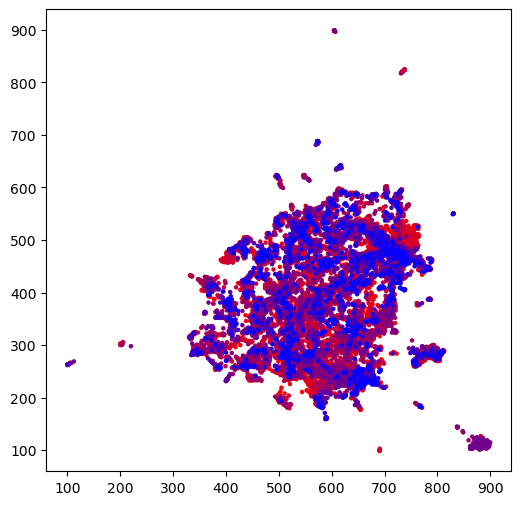

In [35]:
# Suppress the specific UserWarning from UMAP about n_jobs and random_state
warnings.filterwarnings(
    action='ignore',
    message='n_jobs value.*',
    category=UserWarning,
    module='umap'
)

# Define UMAP parameters
umap_params = {
    'random_state': 1,
    'n_components': 2,
    'n_neighbors': 15,  # Adjusted for typical usage
    'min_dist': 0.1,
    'metric': 'hellinger'
}

# Compute UMAP embedding
reducer = umap.UMAP(**umap_params)
embedding = reducer.fit_transform(train_data)

# Scale embeddings
scaler = MinMaxScaler(feature_range=(100, 900))
embedding_scaled = scaler.fit_transform(embedding).astype(int)

# Assign embeddings to 'x' and 'y' in the DataFrame
df["x"], df["y"] = embedding_scaled[:, 0], embedding_scaled[:, 1]

# Adjust the figure size to make the plot smaller
plt.figure(figsize=(6, 6), dpi=100)  # Reduced width and height
plt.scatter(df["x"], df["y"], s=5, c=df["color"])

## Clustering

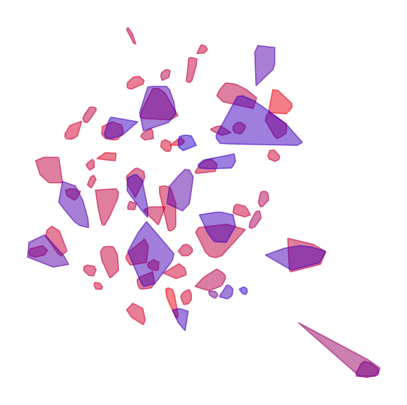

In [36]:
df["cluster"] = "-1"  # Initialize 'cluster' column

hdbscan_params = {
    "min_cluster_size": 50,
    # "min_samples": 4,
    "cluster_selection_epsilon": 0.2,
    # 'metric': 'haversine'
    'cluster_selection_method': 'leaf',
}

# Define conditions and prefixes
conditions = [(df["temperature"] > 0, "p_"), (df["temperature"] <= 0, "n_")]

# Perform clustering and assign labels
for condition, prefix in conditions:
    indices = df.index[condition]
    embedding = df.loc[indices, ["x", "y"]].to_numpy()

    # Initialize and fit the HDBSCAN clusterer with parameters
    clusterer = hdbscan.HDBSCAN(**hdbscan_params)
    labels = clusterer.fit_predict(embedding)

    # Apply prefix to cluster labels
    df.loc[indices, "cluster"] = [
        f"{prefix}{label}" if label != -1 else str(label) for label in labels
    ]

##
## Visualization
##



plt.figure(figsize=(5, 5))
plt.axis("off")

# Get unique cluster labels
clusters = [cluster for cluster in df["cluster"].unique() if cluster != "-1"]

# print(clusters)

for cluster in clusters:
    # Get data for the current cluster
    cluster_data = df[df["cluster"] == cluster]
    cluster_points = cluster_data[["x", "y"]].values
    cluster_colors = cluster_data["color"].values  # Array of colors

    # Need at least 3 points to compute a convex hull
    # if len(cluster_points) < 3:
    #     print(f"Cluster '{cluster}' has less than 3 points ({len(cluster_points)}). Skipping.")
    #     continue

    # Compute the convex hull
    hull = ConvexHull(cluster_points)
    hull_vertices = cluster_points[hull.vertices]

    # Close the hull by appending the first point at the end
    x_hull = np.append(hull_vertices[:, 0], hull_vertices[0, 0])
    y_hull = np.append(hull_vertices[:, 1], hull_vertices[0, 1])

    # Convert colors to RGB format
    rgb_colors = []
    for color in cluster_colors:
        try:
            rgb = mcolors.to_rgb(color)
            rgb_colors.append(rgb)
        except ValueError:
            print(f"Invalid color '{color}' in cluster '{cluster}'. Using default color.")
            rgb_colors.append((0, 0, 0))  # Default to black if color is invalid

    # Compute average RGB values
    avg_rgb = np.mean(rgb_colors, axis=0)

    # Ensure RGB values are within [0, 1]
    avg_rgb = np.clip(avg_rgb, 0, 1)

    # Convert average RGB back to hex color
    avg_color_hex = mcolors.to_hex(avg_rgb)

    # Plot the convex hull with the average color
    plt.fill(x_hull, y_hull, color=avg_color_hex, alpha=0.5)

plt.show()


## Frequency

In [43]:
def get_top_n_words(lemmas_column, n_top_words=20):
    """
    Gets the n most common words and their frequencies from a column with lists of words.

    Args:
        lemmas_column (pd.Series): Column containing lists of words.
        n_top_words (int): Number of most frequent words to return.

    Returns:
        tuple: List of most common words and list of their corresponding frequencies.
    """
    # Flatten all lists into a single list
    all_words = [word for lemmas_list in lemmas_column for word in lemmas_list]
    
    # Count the frequency of each word
    word_counts = Counter(all_words)
    
    # Get the most common words
    most_common = word_counts.most_common(n_top_words)
    
    # Separate words and frequencies
    top_words = [word for word, count in most_common]
    top_counts = [count for word, count in most_common]
    
    return top_words, top_counts


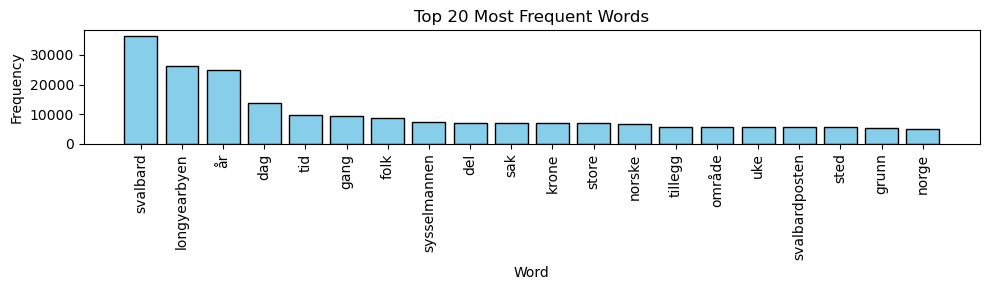

In [38]:
# Get the 20 most common words
n_top_words = 20
top_words, top_counts = get_top_n_words(df['lemmas'], n_top_words=n_top_words)

# Plot the most common words
plt.figure(figsize=(10, 3))
plt.bar(top_words, top_counts, color='skyblue', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title(f'Top {n_top_words} Most Frequent Words')
plt.tight_layout()
plt.show()


In [39]:
# Palabras adicionales a eliminar
manual_words = {'download', 'newsletter'}
def remove_top_words(lemmas_column, words_to_remove, manual_words=None):
    """
    Removes the most common words and additional manually specified words 
    from each list in the lemmas column.

    Args:
        lemmas_column (pd.Series): Column containing lists of words.
        words_to_remove (set): Set of words to be removed.
        manual_words (set, optional): Additional words to remove. Default is None.

    Returns:
        pd.Series: New column with lists of words excluding the specified ones.
    """
    # Combina las palabras a eliminar con las palabras manuales
    combined_words_to_remove = words_to_remove.union(manual_words or set())

    # Aplica el filtrado
    return lemmas_column.apply(
        lambda lemmas: [word for word in lemmas if word not in combined_words_to_remove]
    )


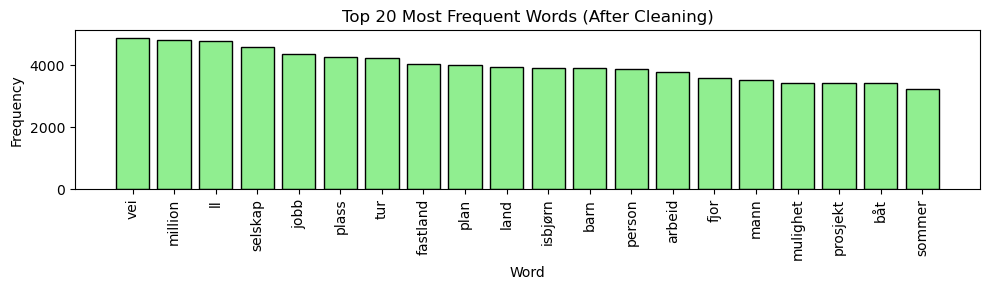

In [40]:
# Clean the articles by removing the most common words
words_to_remove = set(top_words)  # Convert to a set for fast lookups
df['lemmas_cleaned'] = remove_top_words(df['lemmas'], words_to_remove, manual_words)

# Get the most common words after cleaning
top_words_cleaned, top_counts_cleaned = get_top_n_words(df['lemmas_cleaned'], n_top_words=n_top_words)

# Plot the most common words after cleaning
plt.figure(figsize=(10, 3))
plt.bar(top_words_cleaned, top_counts_cleaned, color='lightgreen', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title(f'Top {n_top_words} Most Frequent Words (After Cleaning)')
plt.tight_layout()
plt.show()

In [41]:

# Extract keywords for each cluster
def extract_keywords(df, top_n=15, max_features=1000):
    results = []

    for cluster_id, group in df.groupby("cluster"):
        # Vectorize the text
        vectorizer = CountVectorizer(max_features=max_features)
        lemmas = group["lemmas_cleaned"] = group["lemmas_cleaned"].apply(
            lambda x: " ".join(x) if isinstance(x, list) else str(x)
        )
        # print(group["lemmas"])
        # print(test)
        # print(" ".join(group['lemmas']))
        X = vectorizer.fit_transform(lemmas)

        # Calculate word frequencies
        word_sums = X.sum(axis=0).A1  # Convert matrix to array
        words_freq = sorted(
            ((word, word_sums[idx]) for word, idx in vectorizer.vocabulary_.items()),
            key=lambda x: x[1], reverse=True
        )

        # Get top keywords
        top_keywords = [word for word, _ in words_freq[:top_n]]

        # Append cluster results
        results.append({'cluster': cluster_id, 'top_keywords': top_keywords})

    return pd.DataFrame(results)


# Usage
keywords_df = extract_keywords(df)

keywords_df

,cluster,top_keywords
0,-1,"[selskap, tur, vei, million, ll, isbjørn, land..."
1,n_0,"[said, new, people, norwegian, company, good, ..."
2,n_1,"[konsert, festival, band, scene, artist, publi..."
3,n_10,"[hermansen, selskap, robert, million, avtale, ..."
4,n_11,"[kull, tonn, svea, gruve, selskap, million, ar..."
...,...,...
63,p_5,"[selmer, sykehus, person, test, tiltak, fastla..."
64,p_6,"[sykehus, beredskap, tromsø, jetfly, pasient, ..."
65,p_7,"[skimaraton, løp, løype, turn, mål, lørdag, li..."
66,p_8,"[turn, friluft, aktiv, hagen, barn, bakke, tur..."


## GPT

In [47]:
# Load environment variables from a .env file
load_dotenv('password.txt')

# Get the API key from the environment variable
api_key = os.getenv('OPENAI_API_KEY')

# Initialize OpenAI client
client = OpenAI(api_key=api_key)

# Initialize a dictionary to store the cluster subjects
cluster_subjects = {}

# Iterate over each cluster in the keywords_df
for cluster_id in keywords_df['cluster'].unique():
    # Get the top keywords for the current cluster
    top_keywords = keywords_df[keywords_df['cluster'] == cluster_id]['top_keywords'].iloc[0]

    # Convert the list of keywords into a string to pass to the API
    keywords_text = ", ".join(top_keywords)

    try:
        # Send the request to the ChatGPT API
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an expert in text analysis and Svalbard with a background in library science."},
                {"role": "user", "content": f"Can you tell me, in two/three words, which is the subject of the cluster starting from a list of keywords ordered by frequency? Please avoid any comment, so that we can copy and paste your two/three words immediately. Also avoid punctuation and generic subjects. This is the list of top keywords for one cluster, in Norvegian: \n\n{keywords_text}"}
            ],
            max_tokens=50
        )

        # Extract the response content as the subject for this cluster
        subject = response.choices[0].message.content.strip()
    except Exception as e:
        # Handle any API errors
        print(f"Error generating subject for cluster {cluster_id}: {e}")
        subject = "N/A"

    # Store the subject in the dictionary
    cluster_subjects[cluster_id] = subject

# Add the cluster subjects as a new column to the keywords_df
keywords_df['cluster_subject'] = keywords_df['cluster'].map(cluster_subjects)

# Display the keywords_df with the new column
keywords_df

,cluster,top_keywords,cluster_subject
0,-1,"[selskap, tur, vei, million, ll, isbjørn, land...",Svalbard tourism industry
1,n_0,"[said, new, people, norwegian, company, good, ...",Norwegian Arctic Research
2,n_1,"[konsert, festival, band, scene, artist, publi...",Musikk Festival Konsert
3,n_10,"[hermansen, selskap, robert, million, avtale, ...",Hermansen selskap korrupsjon
4,n_11,"[kull, tonn, svea, gruve, selskap, million, ar...",Svea Coal Production
...,...,...,...
63,p_5,"[selmer, sykehus, person, test, tiltak, fastla...",Selmer sykehus smitte
64,p_6,"[sykehus, beredskap, tromsø, jetfly, pasient, ...",Emergensi helse-tjenester
65,p_7,"[skimaraton, løp, løype, turn, mål, lørdag, li...",Ski Marathon Event
66,p_8,"[turn, friluft, aktiv, hagen, barn, bakke, tur...",Outdoor Children Activity


In [48]:
# Realizar el merge
df_merged = pd.merge(df, keywords_df, on='cluster', how='left')
df_merged.sample(1)

,bodytext,created,created_by_name,id,published,published_url,subtitle,tags,title,year,...,parsing,lemmas,temperature,color,x,y,cluster,lemmas_cleaned,top_keywords,cluster_subject
4817,Det opplyser LL på sine hjemmesider mandag kve...,2021-01-03T23:25:00+01:00,"Woldbrand Guldstad, Alexander",208488.0,2021-01-03 22:25:00+00:00,/koronakrisen/stenger-idrettshallen/208488,Longyearbyen lokalstyre (LL) stenger idrettsha...,"nyheter, koronakrisen",Stenger idrettshallen,2021,...,"(Det, opplyser, LL, på, sine, hjemmesider, man...","[ll, hjemmeside, mandag, kveld, bakgrunn, regj...",6,#d4002a,405,462,p_5,"[ll, hjemmeside, mandag, kveld, bakgrunn, regj...","[selmer, sykehus, person, test, tiltak, fastla...",Selmer sykehus smitte


In [49]:
# Select desired cluster
selected_cluster = 'p_2'  # Change to the cluster you want

# Filter the DataFrame by cluster
filtered_df = df[df['cluster'] == selected_cluster]

# Select 5 random URLs from the cluster
random_urls = filtered_df.sample(n=5, replace=False, random_state=42) if len(filtered_df) >= 5 else filtered_df

# Display the selected URLs
print(f"Selected cluster: {selected_cluster}")
print("Random URLs:")
print(random_urls['title'].to_list())


Selected cluster: p_2
Random URLs:
['«Frivillighetsgudinnen» Vigdis', 'Feiret seg selv og de første 25 årene', 'Konfirmant og luftakrobat', 'Et fyrverkeri av en konsert', 'Dundret polarjazzen i gang']


## Polarization

In [51]:
# Download the resource if it's not already available
nltk.download('opinion_lexicon')

# Lists of positive and negative words
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Example
print(f"Total positive words: {len(positive_words)}")
print(f"Total negative words: {len(negative_words)}")


Total positive words: 2006
Total negative words: 4783


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/dario/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [53]:

# Function to compute metrics for each text
def analyze_polarization(text):
    words = text.lower().split()
    word_count = Counter(words)
    positives = sum(word_count[word] for word in positive_words if word in word_count)
    negatives = sum(word_count[word] for word in negative_words if word in word_count)
    
    # Narrative tension (total emotional words)
    tension = positives + negatives
    
    # Balance (minimum between positives and negatives)
    balance = min(positives, negatives)
    
    # Polarization: Proportion of balance relative to tension
    polarization = balance / tension if tension > 0 else 0
    
    return positives, negatives, tension, balance, polarization

# Apply the function to each text and decompose the results into separate columns
df_merged[['positives', 'negatives', 'tension', 'balance', 'polarization']] = df_merged['bodytext'].apply(
    lambda x: pd.Series(analyze_polarization(x))
)

# Group by cluster and cluster_subject, and calculate aggregate metrics
cluster_summary = df_merged.groupby(['cluster', 'cluster_subject']).agg({
    'positives': 'sum',
    'negatives': 'sum',
    'tension': 'sum',
    'balance': 'sum',
    'polarization': 'mean'  # Average polarization
}).reset_index()

# Sort clusters by polarization
cluster_summary = cluster_summary.sort_values(by='tension', ascending=False)

# Print the summary
cluster_summary.head(5)

,cluster,cluster_subject,positives,negatives,tension,balance,polarization
0,-1,Svalbard tourism industry,5303.0,6465.0,11768.0,2380.0,0.081532
1,n_0,Norwegian Arctic Research,3127.0,2312.0,5439.0,1880.0,0.330949
19,p_0,Norwegian research developments,2258.0,1670.0,3928.0,1308.0,0.297776
10,n_17,Arctic helicopter rescue,276.0,185.0,461.0,65.0,0.032856
31,p_2,Musikk Festival Konsert,198.0,251.0,449.0,104.0,0.108412


## Save

In [57]:
# Assuming df_merged and cluster_summary are the two datasets
df_combined = df_merged.merge(cluster_summary, on="cluster", how="inner")
df_combined = df_combined.drop(columns=["bodytext", "parsing", "lemmas", "lemmas_cleaned"])
df_combined = df_combined[df_combined['cluster'] != '-1'] # remove cluster -1

# Display the merged dataset
df_combined.sample(1)
df_combined.to_csv("../src/data/entities.csv", index=False)